# **Neural Style Transfer**

---




---
Neural style transfer is an optimization technique used to take two images—a content image and a style reference image (such as an artwork by a famous painter)—and blend them together so the output image looks like the content image, but “painted” in the style of the style reference image.

This is implemented by optimizing the output image to match the content statistics of the content image and the style statistics of the style reference image. These statistics are extracted from the images using a convolutional network.
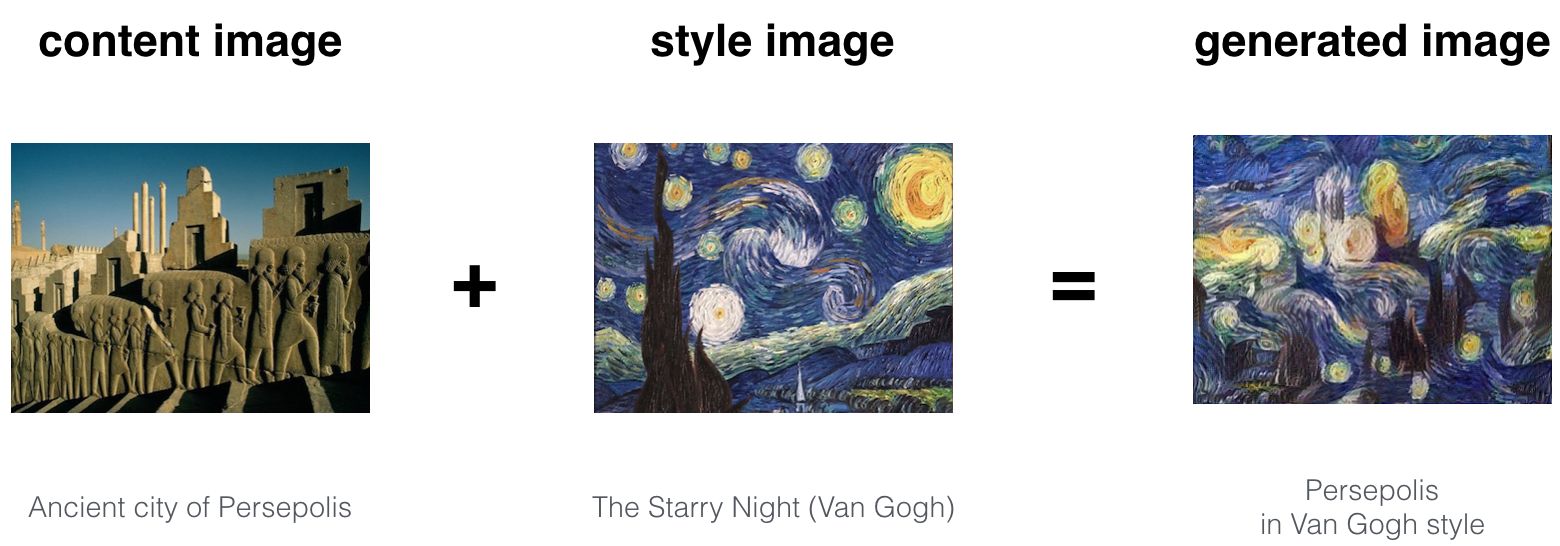



## Importing Packages

In [ ]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
import pprint
%matplotlib inline

# Transfer Learning
Neural Style Transfer (NST) uses a previously trained convolutional network, and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called transfer learning.

We will be using the the epynomously named VGG network from the original NST paper published by the Visual Geometry Group at University of Oxford in 2014. Specifically, you'll use VGG-19, a 19-layer version of the VGG network. This model has already been trained on the very large ImageNet database, and has learned to recognize a variety of low level features (at the shallower layers) and high level features (at the deeper layers).



In [ ]:
tf.random.set_seed(272) 
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

vgg.trainable = False
pp.pprint(vgg)

#**Loss functions** 
We define two loss functions; the **content loss function** and the **style loss functio**n. 
  

1.  The **content loss function** ensures that the activations of the higher layers are similar between the content image and the generated image.
2.   The **style loss function** makes sure that the correlation of activations in all the layers are similar between the style image and the generated image.



# **Content Cost Function**  𝐽𝑐𝑜𝑛𝑡𝑒𝑛𝑡(𝐶,𝐺) 
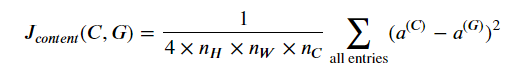

In [ ]:
def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    ### START CODE HERE
    
    # Retrieve dimensions from a_G (≈1 line)
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.reshape(a_C, shape=[_, n_H * n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[_, n_H * n_W, n_C])
    # compute the cost with tensorflow (≈1 line)
    J_content = (1/(4*n_H*n_W*n_C))*tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))
    
    ### END CODE HERE
    
    return J_content

# **Style Cost** 

##Gram matrix

* The style matrix is also called a "Gram matrix."
* In linear algebra, the Gram matrix G of a set of vectors  (𝑣1,…,𝑣𝑛)  is the matrix of dot products, whose entries are  𝐺𝑖𝑗=(𝑣i)^T 𝑣𝑗=𝑛𝑝.𝑑𝑜𝑡
(𝑣𝑖,𝑣𝑗) .
* In other words,  𝐺𝑖𝑗  compares how similar  𝑣𝑖  is to  𝑣𝑗 : If they are highly similar, you would expect them to have a large dot product, and thus for  𝐺𝑖𝑗  to be large.

In [ ]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """  
    ### START CODE HERE
    
    #(≈1 line)
    GA = tf.matmul(A, tf.transpose(A))
    
    ### END CODE HERE

    return GA

# **Style Cost Function** 𝐽𝑠𝑡𝑦𝑙𝑒(𝑆,𝐺)

### Style Cost  for Single layer
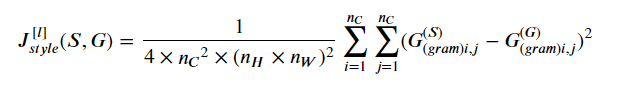

In [ ]:

def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    ### START CODE HERE
    
    # Retrieve dimensions from a_G (≈1 line)
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images from (n_H * n_W, n_C) to have them of shape (n_C, n_H * n_W) (≈2 lines)
    a_S = tf.transpose(tf.reshape(a_S, ([n_H*n_W, n_C])))
    a_G = tf.transpose(tf.reshape(a_G, ([n_H*n_W, n_C])))

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    J_style_layer = 1./(4*n_C**2 *(n_H*n_W)**2)*tf.reduce_sum(tf.pow((GS - GG), 2))
    #J_style_layer = None
    
    ### END CODE HERE
    
    return J_style_layer

In [ ]:
for layer in vgg.layers:
    print(layer.name)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


### Total Style Cost for Style Layers
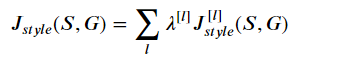

In [ ]:
STYLE_LAYERS = [
    ('block1_conv2', 0.2),
    ('block2_conv2', 0.2),
    ('block3_conv3', 0.2),
    ('block4_conv4', 0.2),
    ('block5_conv4', 0.2)]

In [ ]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    style_image_output -- our tensorflow model
    generated_image_output --
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    # The last element of the array contains the content layer image, which must not be used.
    a_S = style_image_output[:-1]

    # Set a_G to be the output of the choosen hidden layers.
    # The last element of the list contains the content layer image which must not be used.
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style

# **Total Cost to Optimize**
Finally, we will create a cost function that minimizes both the style and the content cost. The formula is:

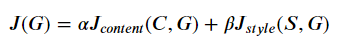

In [ ]:

@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    ### START CODE HERE
    
    #(≈1 line)
    J =  alpha*J_content + beta*J_style
    
    ### START CODE HERE

    return J

# **Loading the Content Image**

(1, 400, 400, 3)


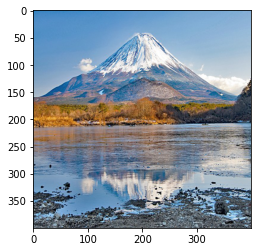

In [ ]:
content_image = np.array(Image.open("fuji.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

# **Load the Style Image**

(1, 400, 400, 3)


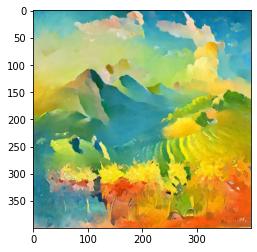

In [ ]:
style_image =  np.array(Image.open("color.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

# **Initializing the "generated" image as a noisy image created from the content_image**

(1, 400, 400, 3)


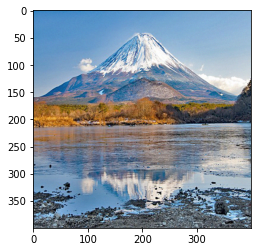

In [ ]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.016, 0.016)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

# **Loading the Pre-trained VGG19 Model**

In [ ]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(name[0]).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [ ]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [ ]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style enconder

# **Computing Total Cost**

### Compute the Content image Encoding (a_C)

In [ ]:
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

### Compute the Style image Encoding (a_S)

In [ ]:
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

In [ ]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    
    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image
    
    Arguments:
    tensor -- Tensor
    
    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

# **Train Step Function for transfer learning**

In [ ]:

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.99, epsilon=1e-1)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        # In this function you must use the precomputed encoded images a_S and a_C
        # Compute a_G as the vgg_model_outputs for the current generated image
        
        ### START CODE HERE
        
        #(1 line)
        a_G = vgg_model_outputs(generated_image)
        
        # Compute the style cost
        #(1 line)
        J_style = compute_style_cost(a_S,a_G)

        #(2 lines)
        # Compute the content cost
        J_content = compute_content_cost(a_C,a_G)
        # Compute the total cost
        J = total_cost( J_content, J_style, alpha = 1, beta = 1e9 ) 
        
        ### END CODE HERE
        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    # For grading purposes
    return J

In [ ]:
# You always must run the last cell before this one. You will get an error if not.
generated_image = tf.Variable(generated_image)


J1 = train_step(generated_image)
print(J1)


J2 = train_step(generated_image)
print(J2)

tf.Tensor(33611522000.0, shape=(), dtype=float32)
tf.Tensor(31872856000.0, shape=(), dtype=float32)


# **Training the Model**

Epoch 0 


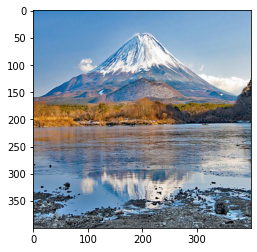

Epoch 250 


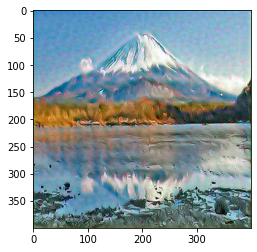

Epoch 500 


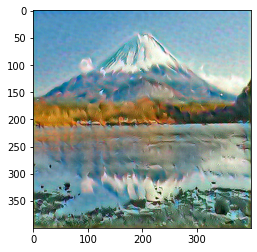

Epoch 750 


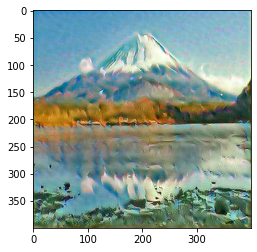

Epoch 1000 


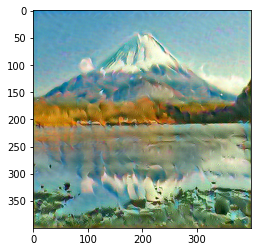

Epoch 1250 


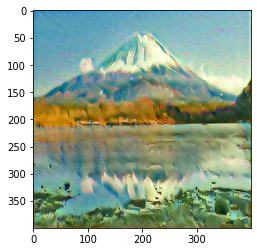

Epoch 1500 


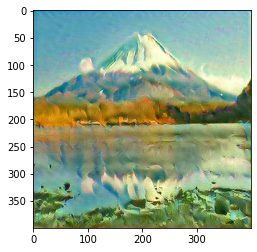

Epoch 1750 


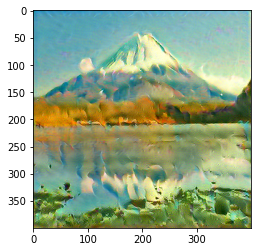

Epoch 2000 


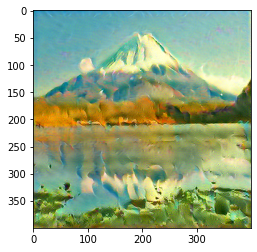

Epoch 2250 


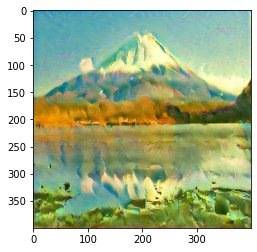

Epoch 2500 


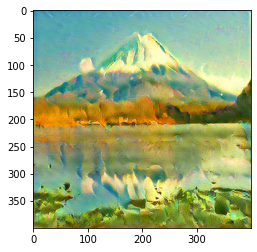

Epoch 2750 


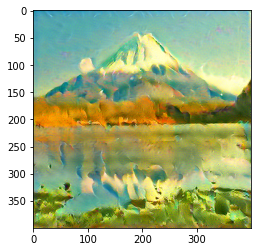

Epoch 3000 


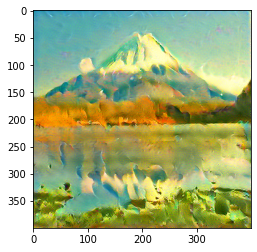

Epoch 3250 


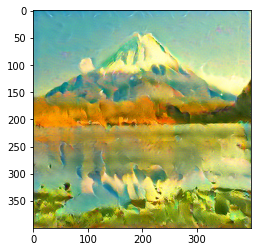

Epoch 3500 


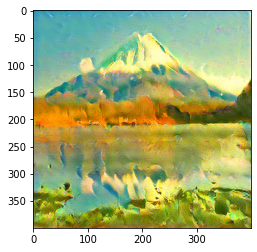

Epoch 3750 


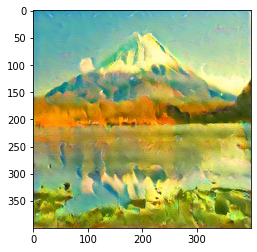

In [ ]:
epochs = 4000
for i in range(epochs):
    train_step(generated_image)
    if i % 250 == 0:
        print(f"Epoch {i} ")
    if i % 250 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"image_{i}.jpg")
        plt.show() 

# **Result**

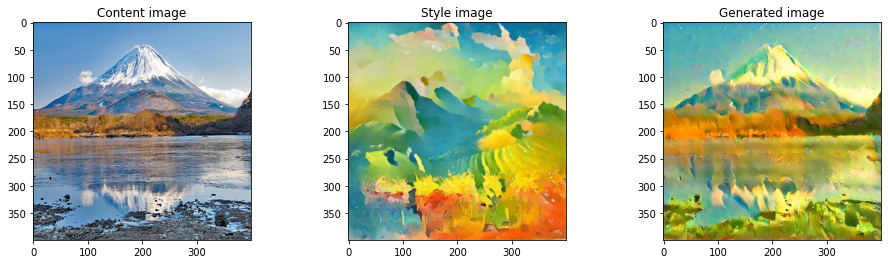

In [ ]:

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()